In [1]:
!git clone https://github.com/hussnain-imtiaz/POI_Analysis.git
!mv /content/POI_Analysis/final_project /content
!mv /content/POI_Analysis/tools /content

Cloning into 'POI_Analysis'...
remote: Enumerating objects: 4687, done.
remote: Counting objects: 100% (4687/4687), done.
remote: Compressing objects: 100% (489/489), done.
remote: Total 4687 (delta 4198), reused 4680 (delta 4196), pack-reused 0
Receiving objects: 100% (4687/4687), 15.00 MiB | 23.20 MiB/s, done.
Resolving deltas: 100% (4198/4198), done.


# Installing all the required tools:
Any missing tool(s) can be installed by using pip command. 


In [ ]:
!pip install pycaret
#!pip install numpy
#!pip install pandas matplotlib seaborn sklearn

# 2. Getting the Tools Ready:

In [3]:
import pandas as pd
import sys
import numpy as np
import pickle
from pycaret.classification import * 
import seaborn as sns
import matplotlib.pyplot as plt

from final_project.tester import dump_classifier_and_data
from tools.feature_format import featureFormat, targetFeatureSplit


# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from final_project.tester import test_classifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


# 3. Loading the data:

In [4]:
### Load the dictionary containing the dataset
with open("/content/final_project/final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

# 4. Getting the data Ready:

In the intial run we will take all the available features and then based on analysis report we will select the best ones. 

In [5]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi', 'salary', 'deferral_payments', 'total_payments', 'loan_advances',
                 'bonus', 'restricted_stock_deferred', 'deferred_income',
                 'total_stock_value', 'expenses', 'exercised_stock_options',
                 'other', 'long_term_incentive', 'restricted_stock', 'director_fees',
                 'to_messages', 'from_poi_to_this_person', 'from_messages',
                 'from_this_person_to_poi', 'shared_receipt_with_poi'] 

In [112]:
### Store to my_dataset for easy export below.
my_dataset = data_dict

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)

### converting the data to df for some analysis and exploration
my_data = pd.DataFrame(data, columns=features_list)
my_data.head()

,poi,salary,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,exercised_stock_options,other,long_term_incentive,restricted_stock,director_fees,to_messages,from_poi_to_this_person,from_messages,from_this_person_to_poi,shared_receipt_with_poi
0,0.0,201955.0,2869717.0,4484442.0,0.0,4175000.0,-126027.0,-3081055.0,1729541.0,13868.0,1729541.0,152.0,304805.0,126027.0,0.0,2902.0,47.0,2195.0,65.0,1407.0
1,0.0,0.0,178980.0,182466.0,0.0,0.0,0.0,0.0,257817.0,3486.0,257817.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,477.0,0.0,916197.0,0.0,0.0,-560222.0,-5104.0,5243487.0,56301.0,4046157.0,864523.0,0.0,1757552.0,0.0,566.0,39.0,29.0,0.0,465.0
3,0.0,267102.0,1295738.0,5634343.0,0.0,1200000.0,0.0,-1386055.0,10623258.0,11200.0,6680544.0,2660303.0,1586055.0,3942714.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,239671.0,260455.0,827696.0,0.0,400000.0,-82782.0,-201641.0,63014.0,129142.0,0.0,69.0,0.0,145796.0,0.0,0.0,0.0,0.0,0.0,0.0


### i. Exploratory Data Analysis

In [59]:
# inspect info
my_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   poi                        145 non-null    float64
 1   salary                     145 non-null    float64
 2   deferral_payments          145 non-null    float64
 3   total_payments             145 non-null    float64
 4   loan_advances              145 non-null    float64
 5   bonus                      145 non-null    float64
 6   restricted_stock_deferred  145 non-null    float64
 7   deferred_income            145 non-null    float64
 8   total_stock_value          145 non-null    float64
 9   expenses                   145 non-null    float64
 10  exercised_stock_options    145 non-null    float64
 11  other                      145 non-null    float64
 12  long_term_incentive        145 non-null    float64
 13  restricted_stock           145 non-null    float64

**We see no missing values because they were imputed with '0'. But it doesnt mean that there is no missing values. We will find their % later.**

#### (A). Total Number of data points and their distribution across different classes (poi/non-poi)

In [8]:
### how many data points we have?
len(my_data)

145

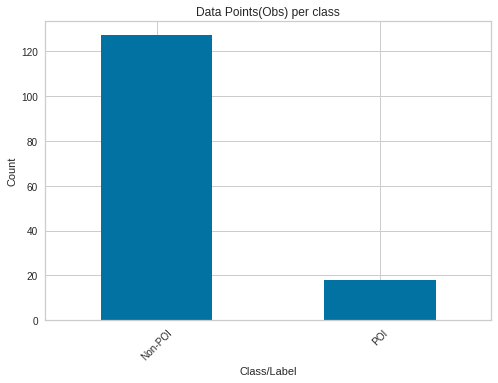

In [9]:
### distribution across different classes
plt.title('Data Points(Obs) per class')
plt.xlabel('Class/Label')
plt.ylabel('Count')
my_data['poi'].value_counts().plot.bar()
plt.xticks([0, 1], labels=['Non-POI', 'POI'], rotation=45)
plt.show()

#### (B). Looking up for the missing values in availble features and filtereing the ones with less than 50% missing values. 

In [10]:
### find how many values are missing in each column
filtered_features_missing = []
missing_count = []
for col in features_list[1:]:
  missing_vals = len(my_data[col][np.where(my_data[col]==0)[0]])
  missing_count.append(missing_vals)
  total_vals = len(my_data[col])
  ptc_missing = missing_vals / total_vals
  if ptc_missing < 0.5:
    filtered_features_missing.append(col)
  print(f'{col} = {ptc_missing:.2f}%')

salary = 0.34%
deferral_payments = 0.73%
total_payments = 0.14%
loan_advances = 0.97%
bonus = 0.43%
restricted_stock_deferred = 0.88%
deferred_income = 0.66%
total_stock_value = 0.13%
expenses = 0.34%
exercised_stock_options = 0.30%
other = 0.36%
long_term_incentive = 0.54%
restricted_stock = 0.24%
director_fees = 0.88%
to_messages = 0.41%
from_poi_to_this_person = 0.49%
from_messages = 0.41%
from_this_person_to_poi = 0.54%
shared_receipt_with_poi = 0.41%


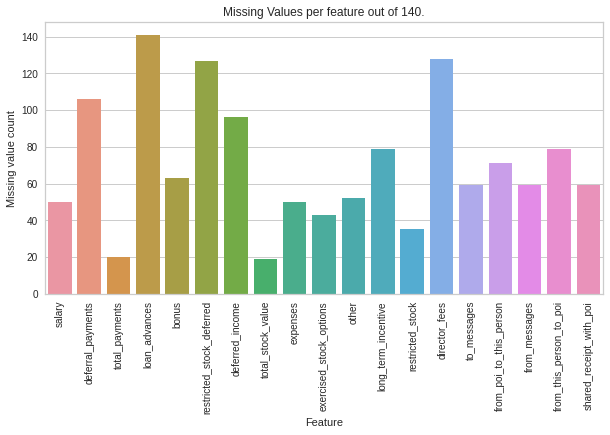

In [11]:
### Visualizing the missing values (by count)
plt.figure(figsize=(10,5))
sns.barplot(x=features_list[1:], y=missing_count)
plt.xticks(rotation=90)
plt.title('Missing Values per feature out of 140.')
plt.xlabel('Feature')
plt.ylabel('Missing value count')
plt.show()

In [12]:
### some filtered features those are having less than 50% missing values
filtered_features_missing

['salary',
 'total_payments',
 'bonus',
 'total_stock_value',
 'expenses',
 'exercised_stock_options',
 'other',
 'restricted_stock',
 'to_messages',
 'from_poi_to_this_person',
 'from_messages',
 'shared_receipt_with_poi']

#### (C). Finding the correlation between dependent and independant variable

In [13]:
my_data.corr().iloc[0]

poi                          1.000000
salary                      -0.001058
deferral_payments           -0.040847
total_payments               0.049386
loan_advances                0.131550
bonus                        0.023341
restricted_stock_deferred   -0.005402
deferred_income             -0.039149
total_stock_value            0.034064
expenses                    -0.009886
exercised_stock_options      0.039922
other                        0.021832
long_term_incentive          0.012467
restricted_stock             0.014801
director_fees               -0.061847
to_messages                  0.110006
from_poi_to_this_person      0.191549
from_messages               -0.033302
from_this_person_to_poi      0.130319
shared_receipt_with_poi      0.242105
Name: poi, dtype: float64

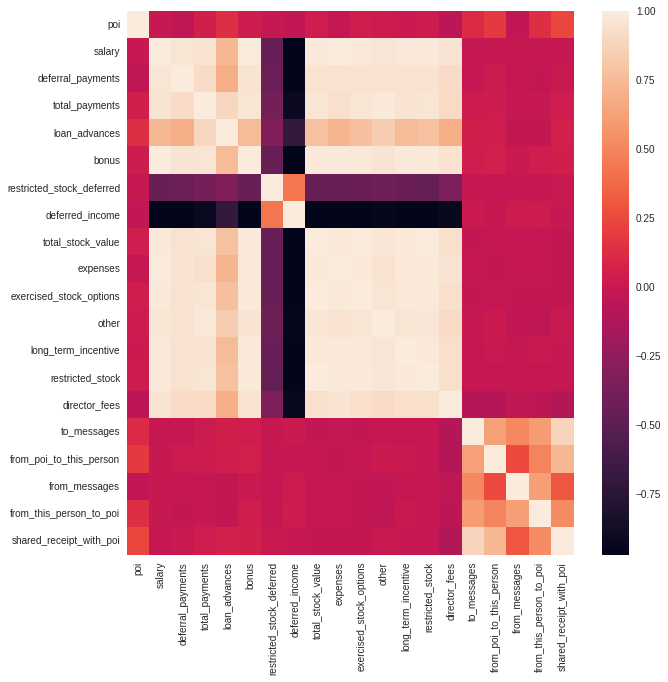

In [ ]:
### find the correlation in all_features
plt.figure(figsize=(10, 10))
sns.heatmap(my_data.corr());

**There is no super corelation.**

#### (D). Is the Data Balanced?

In [14]:
pd.DataFrame(data_dict).T['poi'].value_counts()

False    128
True      18
Name: poi, dtype: int64

**Data is very much imbalanced and more biased to class 0.**

### ii. Data Preparation
We will prepare the data for better analysis and modeling. We will
1. Remove the outliers
2. Create new feature(s)
3. Select higly correlated features

#### 1. Outliers detection and removal

**Inspecting with box plot**

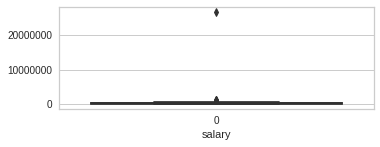

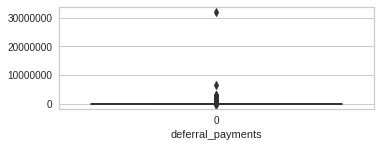

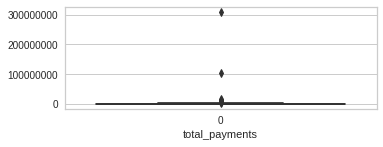

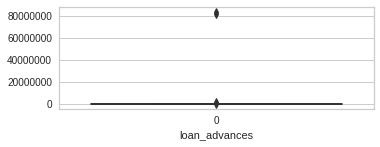

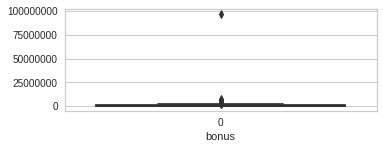

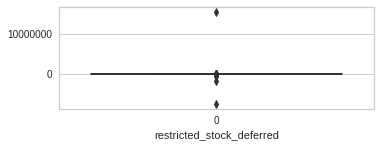

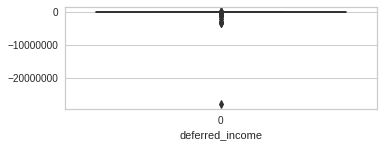

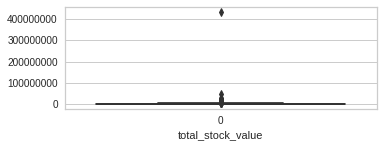

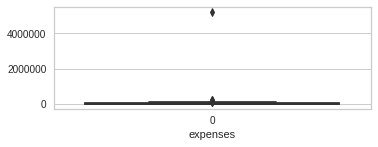

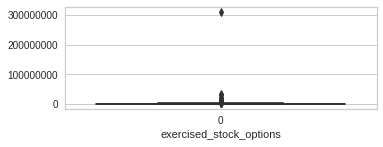

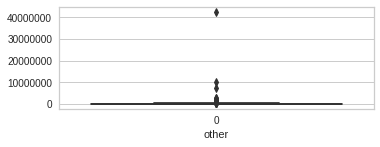

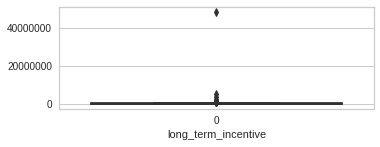

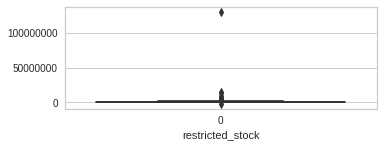

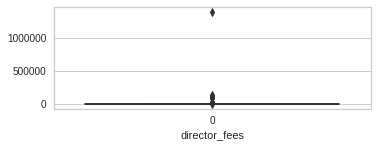

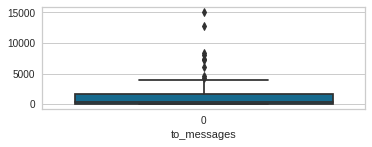

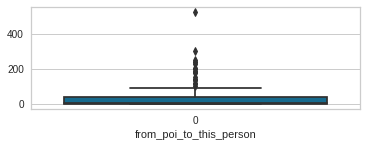

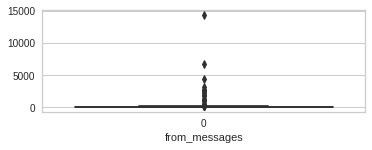

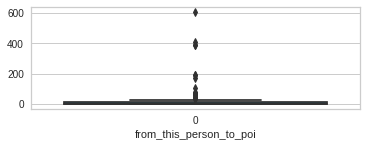

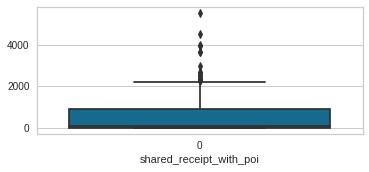

In [60]:
### Task 2: Remove outliers

for i in range(1, len(features_list)):
  plt.figure(figsize = (10,20))
  plt.subplot(10, 2, i)
  sns.boxplot(data=my_data[features_list[i]])
  plt.ticklabel_format(style='plain', axis='y')
  plt.xlabel(features_list[i])
  plt.tight_layout()


In [113]:
my_data[my_data.salary == max(my_data.salary)]

,poi,salary,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,exercised_stock_options,other,long_term_incentive,restricted_stock,director_fees,to_messages,from_poi_to_this_person,from_messages,from_this_person_to_poi,shared_receipt_with_poi
129,0.0,26704229.0,32083396.0,309886585.0,83925000.0,97343619.0,-7576788.0,-27992891.0,434509511.0,5235198.0,311764000.0,42667589.0,48521928.0,130322299.0,1398517.0,0.0,0.0,0.0,0.0,0.0


In [114]:
my_data.head()

,poi,salary,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,exercised_stock_options,other,long_term_incentive,restricted_stock,director_fees,to_messages,from_poi_to_this_person,from_messages,from_this_person_to_poi,shared_receipt_with_poi
0,0.0,201955.0,2869717.0,4484442.0,0.0,4175000.0,-126027.0,-3081055.0,1729541.0,13868.0,1729541.0,152.0,304805.0,126027.0,0.0,2902.0,47.0,2195.0,65.0,1407.0
1,0.0,0.0,178980.0,182466.0,0.0,0.0,0.0,0.0,257817.0,3486.0,257817.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,477.0,0.0,916197.0,0.0,0.0,-560222.0,-5104.0,5243487.0,56301.0,4046157.0,864523.0,0.0,1757552.0,0.0,566.0,39.0,29.0,0.0,465.0
3,0.0,267102.0,1295738.0,5634343.0,0.0,1200000.0,0.0,-1386055.0,10623258.0,11200.0,6680544.0,2660303.0,1586055.0,3942714.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,239671.0,260455.0,827696.0,0.0,400000.0,-82782.0,-201641.0,63014.0,129142.0,0.0,69.0,0.0,145796.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
outlier_index = my_data[my_data.salary == max(my_data.salary)].index

In [116]:
outlier_index

Int64Index([129], dtype='int64')

In [117]:
my_data_selected = my_data.drop(index=outlier_index, axis=1).reset_index(drop=True)

In [118]:
len(my_data_selected)

144

**Using IQR**

In [119]:
# q1 = my_data.quantile(0.25)
# q3 = my_data.quantile(0.75)
# iqr = q3 - q1

In [120]:
# iqr

In [121]:
# (my_data < (q1 - 1.5 * iqr)) | (my_data > (q3 + 1.5 * iqr))

`True` in the data frame above represents the presence of outliers.

In [122]:

# ((my_data > (q3 + 1.5 * iqr)) | (my_data < (q1 - 1.5 * iqr))).any(axis=1)

In [123]:
# ### removal of oultliers based on iqr
# my_data_outliers_rm = my_data[((my_data > (q3 + 1.5 * iqr)) | (my_data < (q1 - 1.5 * iqr))).any(axis=1)]

In [124]:
# my_data_outliers_rm.reset_index(inplace=True, drop=True)

In [125]:
# my_data_outliers_rm

In [126]:
### Task 3: Create new feature(s)
my_data_selected['pct_amount_paid_from_bonus'] = my_data_selected['bonus'] / my_data_selected['total_payments']
my_data_selected.fillna(0, inplace=True)

#### 3. Finding and selecting more correlated features

In [127]:
### selecting only highly correlated featues
highly_corr_feats = []
for label, value in my_data_selected.corr().iloc[0, 1:].items():
  if abs(value) >= 0.1:
    print(label, value)
    highly_corr_feats.append(label)

highly_corr_feats.insert(0, 'poi')
highly_corr_feats

salary 0.3401204273600937
total_payments 0.2424291329992063
loan_advances 0.22029496275696084
bonus 0.3593813036616703
deferred_income -0.27476177874242563
total_stock_value 0.3833815739478593
expenses 0.2050766415219615
exercised_stock_options 0.3875525159574383
other 0.1695900725225276
long_term_incentive 0.25736078932862705
restricted_stock 0.2485093257165224
director_fees -0.12093620374669996
to_messages 0.10872956009833376
from_poi_to_this_person 0.19046003670616699
from_this_person_to_poi 0.12961862780404693
shared_receipt_with_poi 0.24087581278511083
pct_amount_paid_from_bonus 0.35885139548214406


['poi',
 'salary',
 'total_payments',
 'loan_advances',
 'bonus',
 'deferred_income',
 'total_stock_value',
 'expenses',
 'exercised_stock_options',
 'other',
 'long_term_incentive',
 'restricted_stock',
 'director_fees',
 'to_messages',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'shared_receipt_with_poi',
 'pct_amount_paid_from_bonus']

In [128]:
my_data_selected = my_data_selected[highly_corr_feats]
my_data_selected

,poi,salary,total_payments,loan_advances,bonus,deferred_income,total_stock_value,expenses,exercised_stock_options,other,long_term_incentive,restricted_stock,director_fees,to_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi,pct_amount_paid_from_bonus
0,0.0,201955.0,4484442.0,0.0,4175000.0,-3081055.0,1729541.0,13868.0,1729541.0,152.0,304805.0,126027.0,0.0,2902.0,47.0,65.0,1407.0,0.930997
1,0.0,0.0,182466.0,0.0,0.0,0.0,257817.0,3486.0,257817.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,477.0,916197.0,0.0,0.0,-5104.0,5243487.0,56301.0,4046157.0,864523.0,0.0,1757552.0,0.0,566.0,39.0,0.0,465.0,0.000000
3,0.0,267102.0,5634343.0,0.0,1200000.0,-1386055.0,10623258.0,11200.0,6680544.0,2660303.0,1586055.0,3942714.0,0.0,0.0,0.0,0.0,0.0,0.212980
4,0.0,239671.0,827696.0,0.0,400000.0,-201641.0,63014.0,129142.0,0.0,69.0,0.0,145796.0,0.0,0.0,0.0,0.0,0.0,0.483269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.0,0.0,84992.0,0.0,0.0,-25000.0,0.0,1413.0,0.0,0.0,0.0,0.0,108579.0,0.0,0.0,0.0,0.0,0.000000
140,0.0,0.0,189583.0,0.0,0.0,0.0,0.0,0.0,0.0,189583.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
141,0.0,0.0,0.0,0.0,0.0,0.0,139130.0,0.0,139130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
142,1.0,158403.0,360300.0,0.0,0.0,0.0,11884758.0,53947.0,8308552.0,147950.0,0.0,3576206.0,0.0,0.0,0.0,0.0,0.0,0.000000


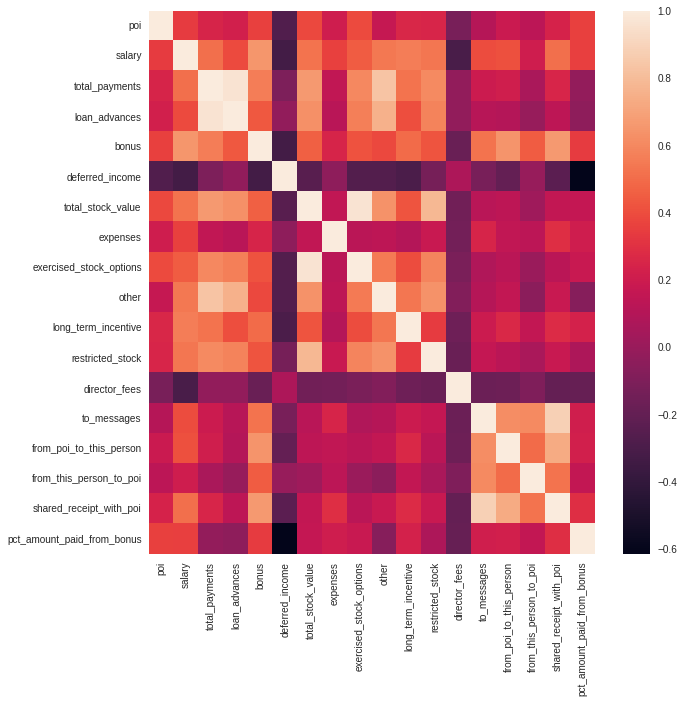

In [129]:
## corelation in filtered features
plt.figure(figsize=(10, 10))
sns.heatmap(my_data_selected.corr());

# Modeling experiments
1. Take the selected features from data as and find the best/highly accurate model.

In [95]:
my_data_selected

,poi,salary,total_payments,loan_advances,bonus,deferred_income,total_stock_value,expenses,exercised_stock_options,other,long_term_incentive,restricted_stock,director_fees,to_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi,pct_amount_paid_from_bonus
0,0.0,201955.0,4484442.0,0.0,4175000.0,-3081055.0,1729541.0,13868.0,1729541.0,152.0,304805.0,126027.0,0.0,2902.0,47.0,65.0,1407.0,0.930997
1,0.0,0.0,182466.0,0.0,0.0,0.0,257817.0,3486.0,257817.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,477.0,916197.0,0.0,0.0,-5104.0,5243487.0,56301.0,4046157.0,864523.0,0.0,1757552.0,0.0,566.0,39.0,0.0,465.0,0.000000
3,0.0,267102.0,5634343.0,0.0,1200000.0,-1386055.0,10623258.0,11200.0,6680544.0,2660303.0,1586055.0,3942714.0,0.0,0.0,0.0,0.0,0.0,0.212980
4,0.0,239671.0,827696.0,0.0,400000.0,-201641.0,63014.0,129142.0,0.0,69.0,0.0,145796.0,0.0,0.0,0.0,0.0,0.0,0.483269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.0,0.0,84992.0,0.0,0.0,-25000.0,0.0,1413.0,0.0,0.0,0.0,0.0,108579.0,0.0,0.0,0.0,0.0,0.000000
140,0.0,0.0,189583.0,0.0,0.0,0.0,0.0,0.0,0.0,189583.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
141,0.0,0.0,0.0,0.0,0.0,0.0,139130.0,0.0,139130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
142,1.0,158403.0,360300.0,0.0,0.0,0.0,11884758.0,53947.0,8308552.0,147950.0,0.0,3576206.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [96]:
experiment = setup(my_data_selected, target='poi')  
best_model = compare_models(sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.87,0.7500,0.35,0.3000,0.3167,0.2837,0.2875,0.080
lightgbm,Light Gradient Boosting Machine,0.85,0.7090,0.40,0.3167,0.3167,0.2592,0.2838,0.027
nb,Naive Bayes,0.78,0.7722,0.30,0.3000,0.2833,0.2125,0.1764,0.019
rf,Random Forest Classifier,0.87,0.8476,0.25,0.3000,0.2667,0.2350,0.2389,0.593
et,Extra Trees Classifier,0.88,0.8514,0.25,0.3000,0.2667,0.2393,0.2444,0.434
ada,Ada Boost Classifier,0.80,0.7201,0.35,0.2167,0.2567,0.1885,0.1958,0.105
dt,Decision Tree Classifier,0.77,0.5938,0.35,0.1833,0.2233,0.1231,0.1436,0.024
lr,Logistic Regression,0.78,0.4562,0.20,0.2000,0.2000,0.0918,0.0811,0.200
qda,Quadratic Discriminant Analysis,0.82,0.5521,0.20,0.1500,0.1667,0.1262,0.1167,0.034
svm,SVM - Linear Kernel,0.74,0.0000,0.25,0.0893,0.1250,0.0105,0.0271,0.026


In [97]:
best_model

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=5362, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

#### best model found in first experiment
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=8895)

In [130]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score

In [131]:
scaller = MinMaxScaler()

best_model = AdaBoostClassifier(random_state = 8895)

#### Model training and evaluation

In [132]:
### testing the best model with tester code
### splitting the selected data into X(features-independent vars) and y (labels-dependent vars)
labels, features = targetFeatureSplit(my_data.values)

### ### scalling the data
features_scalled  = scaller.fit_transform(features)


### split the data in train and test
X_train, X_test, y_train, y_test = train_test_split(features_scalled, labels, test_size=0.2, random_state=42)

In [133]:
### train the model 
best_model.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=8895)

In [134]:
### evaluate the model on testing data
### accuracy
preds = best_model.predict(X_test)

acc = best_model.score(X_test, y_test)
print('Accuracy=', acc)

prec = precision_score(y_test, preds)
print('Precision=', prec)

recall = recall_score(y_test, preds)
print('Recall=', recall)


Accuracy= 0.8275862068965517
Precision= 0.4
Recall= 0.5


In [135]:
my_data_selected.columns

Index(['poi', 'salary', 'total_payments', 'loan_advances', 'bonus',
       'deferred_income', 'total_stock_value', 'expenses',
       'exercised_stock_options', 'other', 'long_term_incentive',
       'restricted_stock', 'director_fees', 'to_messages',
       'from_poi_to_this_person', 'from_this_person_to_poi',
       'shared_receipt_with_poi', 'pct_amount_paid_from_bonus'],
      dtype='object')

In [153]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html


precision, recall, accuracy = test_classifier(best_model, my_data, folds=500)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')
print()

Precision: 0.3498542274052478
Recall: 0.24
Accuracy: 0.8392



### Tuning using the gridsearch cv

In [154]:
from sklearn.model_selection import GridSearchCV

In [155]:
best_model = AdaBoostClassifier(random_state=8895)

In [156]:
params = {
    'base_estimator': [None], 
    'learning_rate' : [0.1, 1.0, 0.01],
    'n_estimators': [20, 50, 100, 150],
    'algorithm': ['SAMME', 'SAMME.R']
    
}

In [157]:
grid_cv = GridSearchCV(best_model, params, scoring='f1', verbose=1)

In [158]:
grid_cv.fit(features_scalled, labels)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   19.1s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=8895),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'base_estimator': [None],
                         'learning_rate': [0.1, 1.0, 0.01],
                         'n_estimators': [20, 50, 100, 150]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=1)

In [159]:
grid_cv.best_params_

{'algorithm': 'SAMME',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50}

In [160]:
best_model = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=8895)

In [161]:
best_model

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=8895)

In [162]:
### train the model 
best_model.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=8895)

In [163]:
X_train.shape

(116, 19)

In [164]:

highly_corr_feats

['poi',
 'salary',
 'total_payments',
 'loan_advances',
 'bonus',
 'deferred_income',
 'total_stock_value',
 'expenses',
 'exercised_stock_options',
 'other',
 'long_term_incentive',
 'restricted_stock',
 'director_fees',
 'to_messages',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'shared_receipt_with_poi',
 'pct_amount_paid_from_bonus']

In [165]:
### find feature importance from model
best_model.feature_importances_

array([0.08, 0.  , 0.12, 0.  , 0.06, 0.  , 0.  , 0.02, 0.18, 0.04, 0.1 ,
       0.  , 0.14, 0.  , 0.  , 0.02, 0.02, 0.14, 0.08])

In [167]:
feature_scores = pd.DataFrame((my_data.columns[1:], best_model.feature_importances_))

In [168]:
feature_scores.transpose()

,0,1
0,salary,0.08
1,deferral_payments,0.0
2,total_payments,0.12
3,loan_advances,0.0
4,bonus,0.06
5,restricted_stock_deferred,0.0
6,deferred_income,0.0
7,total_stock_value,0.02
8,expenses,0.18
9,exercised_stock_options,0.04


In [169]:
## evaluating tuned model with tester script
precision, recall, accuracy = test_classifier(best_model, my_data, folds=500)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')
print()

Precision: 0.396078431372549
Recall: 0.303
Accuracy: 0.8454666666666667



In [172]:
#### saving the classifier
dump_classifier_and_data(best_model, my_dataset, features_list)

In [173]:
### loading the saved model
loaded_model = pickle.load(open('my_classifier.pkl', 'rb'))

In [175]:
## evaluating loaded model with tester script
precision, recall, accuracy = test_classifier(loaded_model, my_data, folds=500)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')
print()

Precision: 0.396078431372549
Recall: 0.303
Accuracy: 0.8454666666666667

